In [11]:
# Core
import os
import importlib
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Model / Feature selection / Scaling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

# Saving Model
import joblib


In [12]:
X_train = pd.read_csv('X_train.csv')
X_test  = pd.read_csv('X_test.csv')

y_train = pd.read_csv('Y_train.csv').squeeze("columns")  
y_test  = pd.read_csv('Y_test.csv').squeeze("columns")    # -> Series

# Optional sanity check
print(y_train.value_counts(dropna=False))
print(y_train.dtype)


Label
LumA      230
LumB      102
Normal     70
Basal      70
Her2       24
Name: count, dtype: int64
object


In [14]:
def get_irus_sampling_strategy(y):
    counts = Counter(y)
    majority_class = max(counts, key=counts.get)
    minority_class = min(counts, key=counts.get)
    imbalance_ratio = counts[majority_class] / counts[minority_class]
    
    # IRUS formula: inverse of square root of imbalance ratio
    sampling_ratio = 1 / np.sqrt(imbalance_ratio)
    
    # Calculate number of samples to keep for majority class
    n_samples_majority = int(counts[minority_class] / sampling_ratio)
    
    return {majority_class: n_samples_majority}

# Get IRUS sampling strategy based on training data
irus_strategy = get_irus_sampling_strategy(y_train)

# Define pipeline with IRUS and RFE for SVM

In [20]:
pipelineSvmIrus = ImbPipeline([
    ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42)) # Using SVC as the final classifier
])

pipelineSvmIrus.fit(X_train, y_train)
y_pred = pipelineSvmIrus.predict(X_test)



Fitting 2 folds for each of 50 candidates, totalling 100 fits
{'svm__C': 695.8780103230359, 'svm__gamma': 1.4583329959038998e-05, 'svm__kernel': 'rbf'}


    mean_test_score  param_svm__C  param_svm__gamma param_svm__kernel
9          0.792757    695.878010          0.000015               rbf
19         0.786075      0.017687          0.000689            linear
27         0.785401      0.009808          0.000001            linear
1          0.781553     47.659118          0.000964               rbf
0          0.779023      0.176702          0.056698              poly
48         0.779023     69.926361          0.030231              poly
43         0.779023      0.016534          0.051793              poly
21         0.779023      0.234910          0.042983              poly
30         0.776481     23.661540          0.007184            linear
45         0.776481      5.573452          0.000030            linear

Test Accuracy (best model): 0.7903225806451613

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.94      0.94        17
        Her2       0.75      0.86      0.

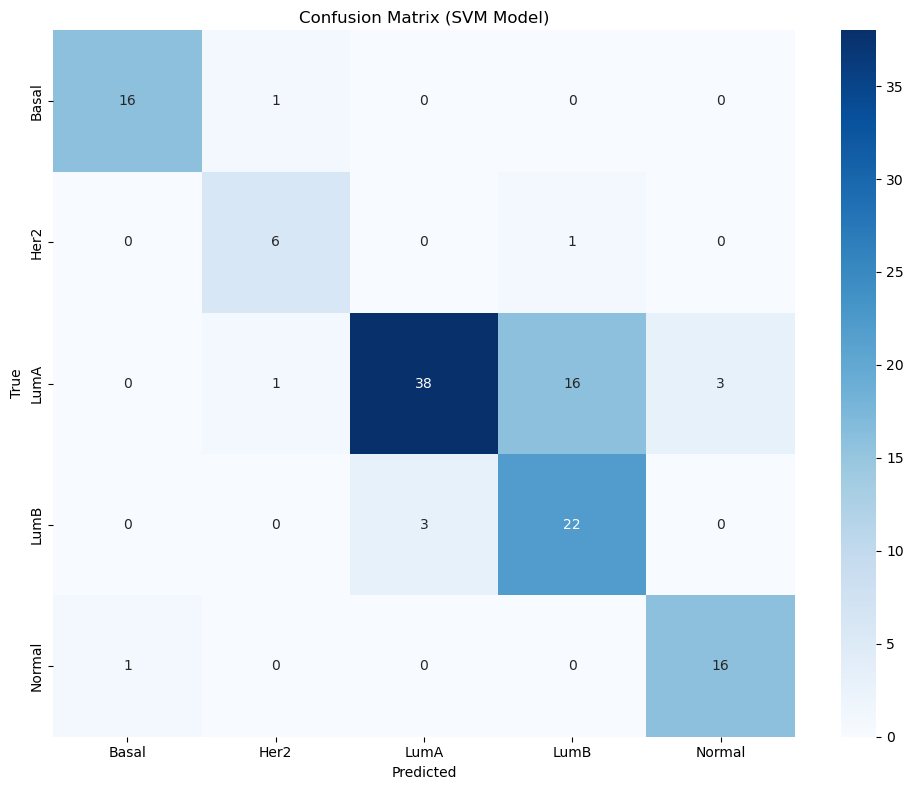

In [24]:
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()